# IBM Data Science Professional Capstone Project
### Using Foursquare Data to Determine Best Neighborhood in Chicago to Open New Pizza Place
##### Modeling and Results

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
from IPython.display import HTML, display

### Load Data

In [2]:
df = pd.read_pickle('./df_for_model.pkl')
print(df.shape)
df.head()

(77, 32)


,Neighborhood,Pizza Place,Latitude,Longitude,WHITE,HISP,BLACK,CARPOOL,INC_100_150K,MEDINC,...,Fried Chicken Joint,Gas Station,Gym,Gym / Fitness Center,High School,Hotel,Italian Restaurant,Mexican Restaurant,Park,Southern / Soul Food Restaurant
0,ALBANY PARK,0.051576,41.96829,-87.72338,15608,24927,2401,2222,2326,58128.20513,...,0.008596,0.000000,0.011461,0.005731,0.005731,0.000000,0.000000,0.017192,0.028653,0.000000
1,ARCHER HEIGHTS,0.032864,41.81154,-87.72556,2213,10181,115,741,520,46632.12435,...,0.004695,0.004695,0.009390,0.009390,0.004695,0.004695,0.004695,0.061033,0.028169,0.000000
2,ARMOUR SQUARE,0.029024,41.83458,-87.63189,1728,538,1218,934,549,26466.21622,...,0.005277,0.000000,0.007916,0.023747,0.034301,0.005277,0.007916,0.010554,0.052770,0.005277
3,ASHBURN,0.054878,41.74785,-87.70995,4745,16924,20837,2296,2393,66560.12658,...,0.024390,0.000000,0.012195,0.006098,0.018293,0.000000,0.006098,0.018293,0.067073,0.000000
4,AUBURN GRESHAM,0.009217,41.74319,-87.65504,324,862,44435,1136,1151,31694.19134,...,0.013825,0.004608,0.000000,0.000000,0.036866,0.000000,0.000000,0.009217,0.050691,0.013825


##### Set X and y sets using target and features

In [3]:
y = df['Pizza Place']

xcols = df.columns.tolist()
xcols = xcols[4:]
X = df[xcols]

print(y.shape)
print(X.shape)

(77,)
(77, 28)


##### Create feature subsets of just demographic and just venue specific information

In [4]:
xcols = X.columns.tolist()
dcols = xcols[0:12]
Xdemo = X[dcols]
Xdemo.head()

,WHITE,HISP,BLACK,CARPOOL,INC_100_150K,MEDINC,OWN_OCC_HU,HV_150_300K,AVG_VMT,VACperc,HCOV75K_LT20PCT,in_lbr_frc_pct
0,15608,24927,2401,2222,2326,58128.20513,6738,2652,11783.649450,0.004454,4574,0.807084
1,2213,10181,115,741,520,46632.12435,2110,1471,13482.202210,0.025773,771,0.805830
2,1728,538,1218,934,549,26466.21622,1927,858,7679.484439,0.023159,823,0.798455
3,4745,16924,20837,2296,2393,66560.12658,10946,6257,17837.275740,0.013212,3808,0.787867
4,324,862,44435,1136,1151,31694.19134,7389,2785,10588.320370,0.050596,2315,0.698409


In [5]:
vcols = xcols[12:]
Xvenue = X[vcols]
Xvenue.head()

,ATM,Bakery,Bar,Cosmetics Shop,Elementary School,Fast Food Restaurant,Fried Chicken Joint,Gas Station,Gym,Gym / Fitness Center,High School,Hotel,Italian Restaurant,Mexican Restaurant,Park,Southern / Soul Food Restaurant
0,0.000000,0.008596,0.022923,0.011461,0.025788,0.008596,0.008596,0.000000,0.011461,0.005731,0.005731,0.000000,0.000000,0.017192,0.028653,0.000000
1,0.004695,0.014085,0.018779,0.018779,0.014085,0.023474,0.004695,0.004695,0.009390,0.009390,0.004695,0.004695,0.004695,0.061033,0.028169,0.000000
2,0.005277,0.013193,0.023747,0.013193,0.015831,0.013193,0.005277,0.000000,0.007916,0.023747,0.034301,0.005277,0.007916,0.010554,0.052770,0.005277
3,0.006098,0.018293,0.018293,0.018293,0.006098,0.024390,0.024390,0.000000,0.012195,0.006098,0.018293,0.000000,0.006098,0.018293,0.067073,0.000000
4,0.000000,0.004608,0.013825,0.027650,0.050691,0.036866,0.013825,0.004608,0.000000,0.000000,0.036866,0.000000,0.000000,0.009217,0.050691,0.013825


##### Create normalized feature set for distance sensitive modeling techniques

In [6]:
from sklearn.preprocessing import StandardScaler

#normalize feature set since KNN uses distance calculation
Xnorm = X.values
Xnorm = StandardScaler().fit_transform(Xnorm)
print(Xnorm.shape)
Xnorm[0]

(77, 28)


array([ 0.25798136,  1.10275617, -0.60760721,  0.8231343 ,  0.32686774,
        0.30040388,  0.15818054,  0.16319065,  0.03849257, -0.82759413,
        0.34686828,  0.58828208, -0.75091718,  0.12733039, -0.06383805,
       -0.17550976,  0.2225946 , -0.6841075 , -0.00611147, -0.61017636,
       -0.06841585, -0.57368258, -0.66384358, -0.4217443 , -0.8789047 ,
       -0.1894568 , -0.72564945, -0.55763963])

In [7]:
Xdemonorm = Xdemo.values
Xdemonorm = StandardScaler().fit_transform(Xdemonorm)
print(Xdemonorm.shape)

Xvenuenorm = Xvenue.values
Xvenuenorm = StandardScaler().fit_transform(Xvenuenorm)
print(Xvenuenorm.shape)

(77, 12)
(77, 16)


##### Create normalized target just in case

In [8]:
yscale = StandardScaler()

ynorm = np.reshape(y,(-1,1))
ynorm = yscale.fit_transform(ynorm)
ynorm = np.reshape(ynorm,-1)
ynorm[0:5]

C:\Users\mkriv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


array([ 1.26002859, -0.00837458, -0.26867693,  1.48386346, -1.61131006])

### Multiple Linear Regression

C:\Users\mkriv\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Cross Validated Train R2s:  0.638740860123
Cross Validated Test R2s:  0.240342871168
Final Model R2: 0.61


Text(0,0.5,'Predicted Values')

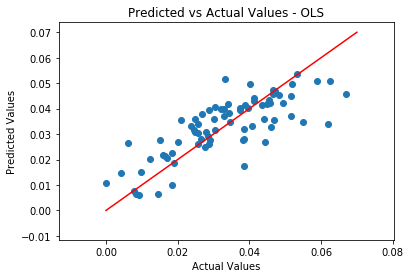

In [9]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate

#create model and score using K fold cross validation
regr = linear_model.LinearRegression()
cv = cross_validate(regr, Xvenue, y,cv=5)
print('Cross Validated Train R2s: ', np.mean(cv['train_score']))
print('Cross Validated Test R2s: ', np.mean(cv['test_score']))

#fit final model
regr.fit(Xvenue, y)

#predicted values
yhat = regr.predict(Xvenue)

# Final Fitted R2
print('Final Model R2: %.2f' % regr.score(Xvenue, y))

plt.scatter(y,yhat)
plt.plot([0,.07],[0,.07],color='red')
plt.title('Predicted vs Actual Values - OLS')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

### Ridge Regression

Cross Validated Train R2s:  0.557577103649
Cross Validated Test R2s:  0.372000952889
Final Model R2: 0.55


C:\Users\mkriv\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Text(0,0.5,'Predicted Values')

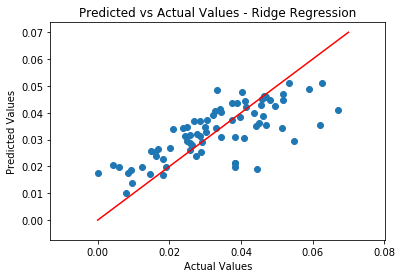

In [10]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate

#create model and score using K fold cross validation
regr = linear_model.Ridge(alpha=0.005)
cv = cross_validate(regr, Xvenue, y,cv=5)
print('Cross Validated Train R2s: ', np.mean(cv['train_score']))
print('Cross Validated Test R2s: ', np.mean(cv['test_score']))

#fit final model
regr.fit(Xvenue, y)

#predicted values
yhat = regr.predict(Xvenue)

# Final Fitted R2
print('Final Model R2: %.2f' % regr.score(Xvenue, y))

plt.scatter(y,yhat)
plt.plot([0,.07],[0,.07],color='red')
plt.title('Predicted vs Actual Values - Ridge Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

### KNN Regression

In [11]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

#set range of neighbors
neighbors=[2,3,4,5,6,7,8,9,10]
parameters = {'n_neighbors': neighbors}

neigh = KNeighborsRegressor()
clf = GridSearchCV(neigh, parameters, cv=5, return_train_score=True)

clf.fit(Xnorm, y)

#review best model
print('Best estimator: ', clf.best_estimator_)
print('Best score: ', clf.best_score_)
print('Best parameters: ', clf.best_params_)

#review top 5 cross validated results
gridresults = pd.DataFrame.from_dict(clf.cv_results_)
gridresults.sort_values(by='rank_test_score').head(5)

Best estimator:  KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=2,
          weights='uniform')
Best score:  0.405591423481
Best parameters:  {'n_neighbors': 4}


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,0.001224,0.001283,0.405591,0.618147,4,{'n_neighbors': 4},1,0.525260,0.583644,0.438704,...,0.322231,0.612358,0.392981,0.593868,0.338596,0.630589,0.000388,0.000433,0.073909,0.030612
3,0.000921,0.001412,0.368429,0.585644,5,{'n_neighbors': 5},2,0.493784,0.540057,0.472000,...,0.178913,0.579828,0.274490,0.588066,0.407698,0.598667,0.000515,0.000331,0.120459,0.026759
8,0.001231,0.001761,0.358349,0.510812,10,{'n_neighbors': 10},3,0.415044,0.499558,0.477580,...,0.149000,0.528544,0.345301,0.528103,0.393094,0.525653,0.000386,0.000457,0.111481,0.022141
7,0.001299,0.001774,0.349662,0.522664,9,{'n_neighbors': 9},4,0.398545,0.521588,0.515556,...,0.096064,0.527001,0.332407,0.522439,0.391418,0.546906,0.000389,0.000469,0.138351,0.016443
5,0.000800,0.001288,0.348889,0.572594,7,{'n_neighbors': 7},5,0.365027,0.528185,0.512761,...,0.052138,0.574697,0.347429,0.599311,0.455090,0.581187,0.000400,0.000395,0.158071,0.023720


R2:  0.63046744409


Text(0,0.5,'Predicted Values')

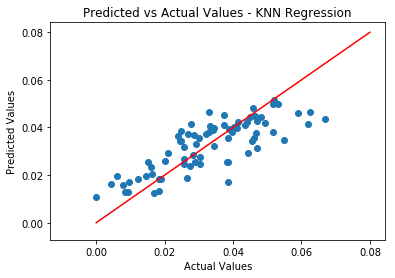

In [12]:
neighfinal = KNeighborsRegressor(n_neighbors=4)
neighfinal.fit(Xnorm,y)
print('R2: ', neighfinal.score(Xnorm,y))

yhatknn = neighfinal.predict(Xnorm)

plt.scatter(y,yhatknn)
plt.plot([0,.08],[0,.08],color='red')
plt.title('Predicted vs Actual Values - KNN Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

### SVM Regression

In [13]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

#set parameters
C_range = np.logspace(-2, 10, 13)
parameters = {'kernel':('poly', 'rbf', 'sigmoid'), 'C':C_range}

#create regression models using gridsearch to find best
#need to use normalized target variable to get meaningful results
svr = SVR()
clf = GridSearchCV(svr, parameters, cv=5, return_train_score=True)
clf.fit(Xvenuenorm, ynorm)

#review best model
print('Best estimator: ', clf.best_estimator_)
print('Best score: ', clf.best_score_)
print('Best parameters: ', clf.best_params_)

#review top 5 cross validated results
gridresults = pd.DataFrame.from_dict(clf.cv_results_)
gridresults.sort_values(by='rank_test_score').head(5)

Best estimator:  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Best score:  0.39075527931
Best parameters:  {'C': 1.0, 'kernel': 'poly'}


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_kernel,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
6,0.001013,0.000783,0.390755,0.756908,1,poly,"{'C': 1.0, 'kernel': 'poly'}",1,0.480324,0.746718,...,0.354213,0.773134,0.513056,0.748763,0.213810,0.741873,2.969168e-05,0.000393,0.104612,0.013809
5,0.000799,0.000797,0.350518,0.444176,0.1,sigmoid,"{'C': 0.1, 'kernel': 'sigmoid'}",2,0.396416,0.376650,...,0.216952,0.463582,0.381248,0.463106,0.386857,0.480570,3.996398e-04,0.000399,0.066411,0.036527
8,0.000998,0.000598,0.334710,0.299755,1,sigmoid,"{'C': 1.0, 'kernel': 'sigmoid'}",3,0.466999,0.216307,...,0.060877,0.337628,0.599301,0.288516,0.135699,0.381470,6.325960e-07,0.000488,0.201049,0.056253
7,0.000628,0.000581,0.329884,0.790318,1,rbf,"{'C': 1.0, 'kernel': 'rbf'}",4,0.361102,0.797796,...,0.197998,0.785623,0.422392,0.787146,0.404969,0.786669,5.210822e-04,0.000476,0.085006,0.004850
3,0.000997,0.000599,0.292296,0.476171,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",5,0.329970,0.448392,...,0.070015,0.482713,0.499198,0.465829,0.253512,0.512837,5.309834e-07,0.000489,0.136338,0.021409


R2:  0.755063234116


Text(0,0.5,'Predicted Values')

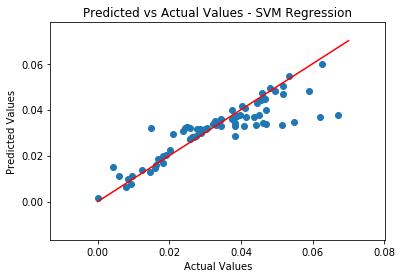

In [14]:
#take params from best gridsearch model
finalsvr = SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

finalsvr.fit(Xvenuenorm,ynorm)

#final R2 score
print('R2: ', finalsvr.score(Xvenuenorm,ynorm))

#make predictions (normalized)
yhatsvrnorm = finalsvr.predict(Xvenuenorm)

#convert back to unscaled values
yhatsvr = yscale.inverse_transform(yhatsvrnorm)

plt.scatter(y,yhatsvr)
plt.plot([0,0.07],[0,0.07],color='red')
plt.title('Predicted vs Actual Values - SVM Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

### Boosted Tree Regression

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

#set parameters
estimators = (10,50,100,500)
losses = ('linear','square','exponential')
lr = (0.1,1,10)
parameters = {'n_estimators': estimators, 'loss': losses, 'learning_rate': lr}

#create regression models using gridsearch to find best
#need to use normalized target variable to get meaningful results
boost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),random_state=30)
clf = GridSearchCV(boost, parameters, cv=5, return_train_score=True)
clf.fit(X, y)

#review best model
print('Best estimator: ', clf.best_estimator_)
print('Best score: ', clf.best_score_)
print('Best parameters: ', clf.best_params_)

#review top 5 cross validated results
gridresults = pd.DataFrame.from_dict(clf.cv_results_)
gridresults.sort_values(by='rank_test_score').head(5)

Best estimator:  AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1, loss='square', n_estimators=500, random_state=30)
Best score:  0.367104142394
Best parameters:  {'learning_rate': 1, 'loss': 'square', 'n_estimators': 500}


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_loss,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
19,1.356147,0.035367,0.367104,0.965693,1,square,500,"{'learning_rate': 1, 'loss': 'square', 'n_esti...",1,0.388262,...,0.064808,0.964881,0.296275,0.974071,0.499861,0.972639,0.081665,0.004174,0.175980,0.008452
15,1.394984,0.035428,0.357885,0.985883,1,linear,500,"{'learning_rate': 1, 'loss': 'linear', 'n_esti...",2,0.408773,...,0.163162,0.986706,0.187588,0.988801,0.464374,0.984702,0.127466,0.004163,0.152978,0.002107
7,1.688831,0.037700,0.352879,0.983591,0.1,square,500,"{'learning_rate': 0.1, 'loss': 'square', 'n_es...",3,0.357504,...,0.105291,0.985218,0.262197,0.985925,0.492785,0.979999,0.174430,0.005586,0.155545,0.002355
18,0.347494,0.009451,0.350249,0.966174,1,square,100,"{'learning_rate': 1, 'loss': 'square', 'n_esti...",4,0.369574,...,0.041038,0.971873,0.335368,0.966244,0.435322,0.975664,0.020695,0.001708,0.169905,0.007678
3,1.611618,0.044499,0.347514,0.985407,0.1,linear,500,"{'learning_rate': 0.1, 'loss': 'linear', 'n_es...",5,0.393221,...,0.115479,0.987376,0.186645,0.988968,0.492014,0.984271,0.108916,0.014909,0.165261,0.003307


R2:  0.956507028936


Text(0,0.5,'Predicted Values')

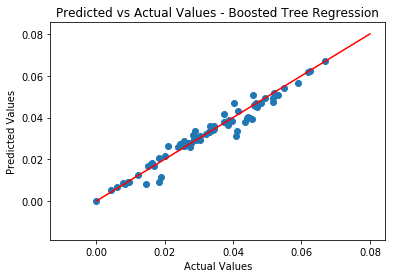

In [16]:
#take params from best gridsearch model
finalboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1, loss='square', n_estimators=500, random_state=30)

finalboost.fit(X,y)

#final R2 score
print('R2: ', finalboost.score(X,y))

#make predictions (normalized)
yhatboost = finalboost.predict(X)

plt.scatter(y,yhatboost)
plt.plot([0,0.08],[0,0.08],color='red')
plt.title('Predicted vs Actual Values - Boosted Tree Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

## Review Best Model Results & Draw Conclusions

##### Results Summary

| Method (with Tuned Parameters) | Train Score | Test Score | Comments
|---|---|---|---|
| Multiple Linear Regression| 0.64 | 0.24 | Potential Overfit
| Ridge Regression | 0.56 | 0.37 | Regularization improved fit
| KNN Regression | 0.62 | 0.41 | Best performer of all
| SVM Regression | 0.76 | 0.39 | Solid but bias to low values
| Boosted Tree Regression | 0.97 | 0.37 | Heavily overfit

##### Using Best Model to Find Opportunity in Chicago Neighborhoods

In [17]:
#add predictions from KNN Regression to original dataset
df_preds = df[['Neighborhood','Latitude','Longitude','Pizza Place']]
df_preds['Prediction'] = yhatknn
df_preds['Opportunity'] = df_preds['Prediction'] - df_preds['Pizza Place']
df_preds.head()

C:\Users\mkriv\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mkriv\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Neighborhood,Latitude,Longitude,Pizza Place,Prediction,Opportunity
0,ALBANY PARK,41.96829,-87.72338,0.051576,0.038152,-0.013424
1,ARCHER HEIGHTS,41.81154,-87.72556,0.032864,0.046391,0.013527
2,ARMOUR SQUARE,41.83458,-87.63189,0.029024,0.032889,0.003866
3,ASHBURN,41.74785,-87.70995,0.054878,0.034679,-0.020199
4,AUBURN GRESHAM,41.74319,-87.65504,0.009217,0.012763,0.003547


##### Which neighborhoods have the most opportunity for new pizza places?

Text(0.5,0,'Pizza Opportunity')

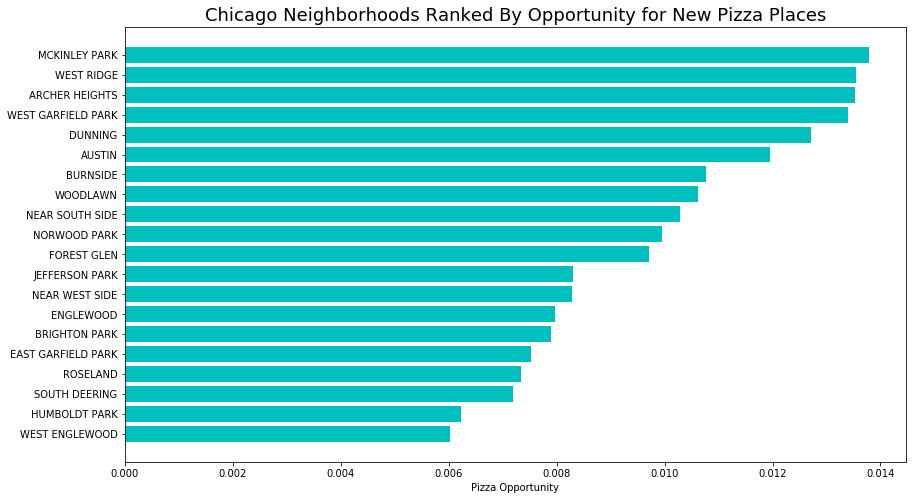

In [18]:
df_preds_sorted = df_preds.sort_values(by='Opportunity')
toptwenty = df_preds_sorted.tail(20).reset_index()
toptwenty.drop(columns='index',inplace=True)

plt.figure(figsize=(14,8))
plt.barh(np.linspace(1,20,20),toptwenty['Opportunity'],tick_label=toptwenty['Neighborhood'],color='c')
plt.title('Chicago Neighborhoods Ranked By Opportunity for New Pizza Places',size=18)
plt.xlabel('Pizza Opportunity')

##### Pizza Opportunity Visualized Spatially

In [19]:
#load geojson for folium maps
with open('chicago-community-areas.geojson') as json_data:
    geo_data = json.load(json_data)
    
def embed_map(m):
    from IPython.display import IFrame

    m.save('index.html')
    return IFrame('index.html', width='100%', height='750px')

m = folium.Map(location=[41.84, -87.6298], zoom_start=10.5)

folium.Choropleth(
    geo_data=geo_data,
    name='choropleth',
    data=df_preds,
    columns=['Neighborhood','Opportunity'],
    key_on='feature.properties.community',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Pizza Place Opportunity'
).add_to(m)

# display map
embed_map(m)

In [22]:
toptwenty.sort_values(by='Opportunity',ascending=False,inplace=True)
toptwenty

,Neighborhood,Latitude,Longitude,Pizza Place,Prediction,Opportunity
19,MCKINLEY PARK,41.82857,-87.67338,0.027778,0.041560,0.013782
18,WEST RIDGE,41.99948,-87.69266,0.024845,0.038399,0.013554
17,ARCHER HEIGHTS,41.81154,-87.72556,0.032864,0.046391,0.013527
16,WEST GARFIELD PARK,41.87702,-87.73074,0.006061,0.019459,0.013399
15,DUNNING,41.95274,-87.79651,0.023810,0.036515,0.012705
14,AUSTIN,41.88774,-87.76392,0.004255,0.016213,0.011958
13,BURNSIDE,41.72031,-87.59750,0.000000,0.010760,0.010760
12,WOODLAWN,41.78046,-87.60135,0.015000,0.025616,0.010616
11,NEAR SOUTH SIDE,41.85388,-87.62711,0.026804,0.037098,0.010294
10,NORWOOD PARK,41.98572,-87.80664,0.024510,0.034463,0.009953
